<a href="https://colab.research.google.com/github/Tutifs/PD/blob/main/TrainVON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##SVM

Accuracy: 96.96%
Recall per class: [0.96330275 1.         1.         0.78846154]
F1 score per class: [0.93333333 1.         1.         0.84536082]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       218
           1       1.00      1.00      1.00       342
           2       1.00      1.00      1.00       322
           3       0.91      0.79      0.85       104

    accuracy                           0.97       986
   macro avg       0.95      0.94      0.94       986
weighted avg       0.97      0.97      0.97       986



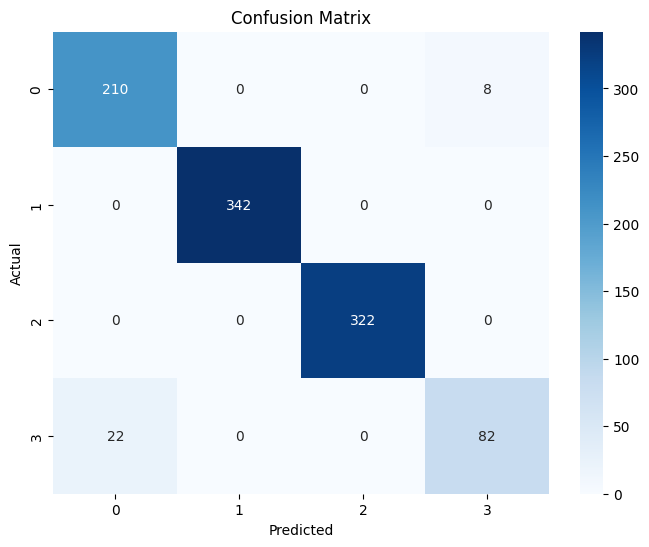

In [3]:
import os
import torch
import numpy as np
import cv2
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Đường dẫn tới hai thư mục chứa ảnh
image_dirs = ['/content/drive/MyDrive/all_image_anhminh/all_image']

class CustomImageDataset(Dataset):
    def __init__(self, image_dirs, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        for image_dir in image_dirs:
            for image_name in os.listdir(image_dir):
                if image_name.startswith(('adjust_0', 'adjust_1', 'adjust_2', 'adjust_3')):
                    image_path = os.path.join(image_dir, image_name)
                    self.image_paths.append(image_path)

                    # Gán nhãn dựa trên tên file
                    if "adjust_0" in image_name:
                        self.labels.append(0)
                    elif "adjust_1" in image_name:
                        self.labels.append(1)
                    elif "adjust_2" in image_name:
                        self.labels.append(2)
                    elif "adjust_3" in image_name:
                        self.labels.append(3)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Định nghĩa các biến đổi cho dữ liệu hình ảnh
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Tạo dataset và dataloader
dataset = CustomImageDataset(image_dirs, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Chuyển đổi dữ liệu từ DataLoader thành các mảng numpy để sử dụng với SVM
X = []
y = []

for images, labels in dataloader:
    images = images.numpy().reshape(images.size(0), -1)  # Flatten images
    X.extend(images)
    y.extend(labels.numpy())

X = np.array(X)
y = np.array(y)

# Áp dụng PCA để giảm chiều dữ liệu
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)

# Chia dữ liệu thành tập train và test
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train mô hình SVM
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred = svm.predict(X_test)

# Tính độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Tính recall, f1 score cho từng lớp
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
print(f'Recall per class: {recall}')
print(f'F1 score per class: {f1}')

# In kết quả chi tiết
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# In confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [4]:
import joblib
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Create directory if it doesn't exist
save_dir = '/content/drive/MyDrive/VonResult/'
os.makedirs(save_dir, exist_ok=True)

# Lưu mô hình SVM
model_filename = os.path.join(save_dir, 'svm_model.pkl')
joblib.dump(svm, model_filename)

# Lưu mô hình PCA
pca_filename = os.path.join(save_dir, 'pca_model.pkl')
joblib.dump(pca, pca_filename)

print(f"Model saved to {model_filename}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to /content/drive/MyDrive/VonResult/svm_model.pkl


In [14]:
import joblib
import numpy as np
from PIL import Image
import torch
from torchvision import transforms

# Định nghĩa các biến đổi cho dữ liệu hình ảnh
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Đảm bảo kích thước hình ảnh giống như khi huấn luyện
    transforms.ToTensor(),        # Chuyển đổi hình ảnh thành tensor
])
pca_loaded = joblib.load('/content/drive/MyDrive/VonResult/pca_model.pkl')
def predict_image(image_path, model, transform):
    # Tải ảnh và chuyển đổi thành định dạng phù hợp
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0)  # Thêm batch dimension

    # Chuyển đổi tensor thành numpy array cho SVM
    image_np = image.numpy().reshape(1, -1)

    # Tiền xử lý dữ liệu giống như khi huấn luyện
    image_pca = pca_loaded.transform(image_np)

    # Dự đoán với mô hình SVM
    prediction = model.predict(image_pca)
    return prediction[0]

# Đường dẫn đến ảnh PNG
image_path = '/content/adjust_2_file10_chunk_0_noisy_filtered.png'
# Tải mô hình SVM
model_filename = '/content/drive/MyDrive/VonResult/svm_model.pkl'
svm_loaded = joblib.load(model_filename)
# Dự đoán
prediction = predict_image(image_path, svm_loaded, transform)
print(f'Predicted label: {prediction}')

Predicted label: 0


##KNN

              precision    recall  f1-score   support

    adjust_0       0.97      0.80      0.88       322
    adjust_1       0.63      0.60      0.61       509
    adjust_2       0.60      0.64      0.62       485
    adjust_3       0.71      0.95      0.81       163

    accuracy                           0.69      1479
   macro avg       0.73      0.74      0.73      1479
weighted avg       0.70      0.69      0.69      1479



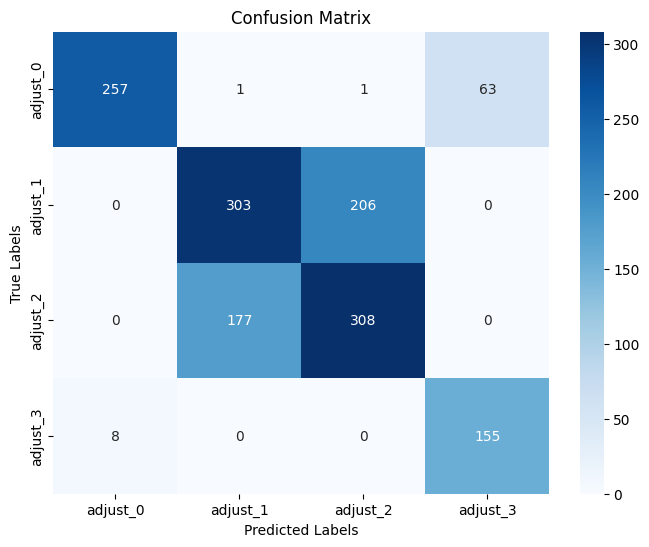

In [6]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Định nghĩa các thư mục chứa ảnh
folders = ['/content/drive/MyDrive/all_image_anhminh/all_image']

# Danh sách để lưu dữ liệu ảnh và nhãn
images = []
labels = []

# Đọc ảnh từ các thư mục
for folder in folders:
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # Thay đổi tùy theo định dạng ảnh
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Đọc ảnh thành ảnh xám
            img = cv2.resize(img, (64, 64))  # Thay đổi kích thước ảnh nếu cần
            images.append(img.flatten())  # Chuyển đổi ảnh thành vector 1D

            # Gán nhãn từ tên file
            if "adjust_0" in filename:
                label = 0
            elif "adjust_1" in filename:
                label = 1
            elif "adjust_2" in filename:
                label = 2
            elif "adjust_3" in filename:
                label = 3
            else:
                continue  # Bỏ qua các file không thuộc dạng này

            labels.append(label)

# Chuyển đổi dữ liệu thành numpy array
X = np.array(images)
y = np.array(labels)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Tạo và huấn luyện mô hình KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Dự đoán và đánh giá mô hình
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['adjust_0', 'adjust_1', 'adjust_2', 'adjust_3']))

# Tạo confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Vẽ confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['adjust_0', 'adjust_1', 'adjust_2', 'adjust_3'],
            yticklabels=['adjust_0', 'adjust_1', 'adjust_2', 'adjust_3'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [7]:
import cv2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# Đọc ảnh PNG mới
def preprocess_image(image_path, target_size=(64, 64)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Đọc ảnh thành ảnh xám
    img = cv2.resize(img, target_size)  # Thay đổi kích thước ảnh
    img_flatten = img.flatten()  # Chuyển đổi ảnh thành vector 1D
    return img_flatten

# Đường dẫn đến ảnh PNG mới
new_image_path = '/content/adjust_0_file10_chunk_0_noisy_filtered.png'

# Tiền xử lý ảnh mới
new_image = preprocess_image(new_image_path)

# Dự đoán nhãn của ảnh mới
def predict_image(model, image_vector):
    # Dự đoán nhãn
    prediction = model.predict([image_vector])
    return prediction[0]



# Dự đoán nhãn của ảnh mới
predicted_label = predict_image(knn, new_image)

# Hiển thị kết quả
print(f'Nhãn dự đoán của ảnh là: {predicted_label}')


Nhãn dự đoán của ảnh là: 3


##Deep Learning

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import os
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, img_dirs, transform=None):
        self.img_dirs = img_dirs
        self.transform = transform
        self.img_labels = self._load_images()

    def _load_images(self):
        img_labels = []
        for img_dir in self.img_dirs:
            img_labels.extend([(file, self._get_label(file)) for file in os.listdir(img_dir) if file.endswith(('.png', '.jpg', '.jpeg'))])
        return img_labels

    def _get_label(self, filename):
        if 'adjust_0' in filename:
            return 0
        elif 'adjust_1' in filename:
            return 1
        elif 'adjust_2' in filename:
            return 2
        elif 'adjust_3' in filename:
            return 3

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dirs[0], self.img_labels[idx][0])
        if not os.path.exists(img_path):  # Check if the file exists in the first directory
            img_path = os.path.join(self.img_dirs[1], self.img_labels[idx][0])  # Fallback to the second directory
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels[idx][1]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define your image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Paths to the image directories
img_dirs = ['/content/drive/MyDrive/all_image_anhminh/all_image']

# Create the dataset
dataset = CustomImageDataset(img_dirs=img_dirs, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # 4 classes: 0, 1, 2, 3
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)







/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


In [9]:
from tqdm import tqdm
num_epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_val_loss = float('inf')
best_model_path = '/content/drive/MyDrive/VonResult/best_model_weights.pth'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        progress_bar.set_postfix({'Loss': running_loss / len(train_loader.dataset)})

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Validation Accuracy: {100 * correct / total:.2f}%')

    # Save the model if the validation loss is the lowest
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f'Saved Best Model with Validation Loss: {best_val_loss:.4f}')

Epoch 1/10: 100%|██████████| 124/124 [01:18<00:00,  1.57batch/s, Loss=0.0937]


Epoch 1/10, Loss: 0.0937
Validation Loss: 0.3539
Validation Accuracy: 88.24%
Saved Best Model with Validation Loss: 0.3539


Epoch 2/10: 100%|██████████| 124/124 [01:18<00:00,  1.58batch/s, Loss=0.0327]


Epoch 2/10, Loss: 0.0327
Validation Loss: 0.0222
Validation Accuracy: 99.39%
Saved Best Model with Validation Loss: 0.0222


Epoch 3/10: 100%|██████████| 124/124 [01:21<00:00,  1.52batch/s, Loss=0.0315]


Epoch 3/10, Loss: 0.0315
Validation Loss: 0.0257
Validation Accuracy: 99.39%


Epoch 4/10: 100%|██████████| 124/124 [01:17<00:00,  1.59batch/s, Loss=0.0578]


Epoch 4/10, Loss: 0.0578
Validation Loss: 1.1835
Validation Accuracy: 64.81%


Epoch 5/10: 100%|██████████| 124/124 [01:17<00:00,  1.61batch/s, Loss=0.0438]


Epoch 5/10, Loss: 0.0438
Validation Loss: 0.0289
Validation Accuracy: 99.39%


Epoch 6/10: 100%|██████████| 124/124 [01:17<00:00,  1.59batch/s, Loss=0.0285]


Epoch 6/10, Loss: 0.0285
Validation Loss: 0.0246
Validation Accuracy: 99.39%


Epoch 7/10: 100%|██████████| 124/124 [01:18<00:00,  1.58batch/s, Loss=0.0442]


Epoch 7/10, Loss: 0.0442
Validation Loss: 0.0852
Validation Accuracy: 97.36%


Epoch 8/10: 100%|██████████| 124/124 [01:17<00:00,  1.60batch/s, Loss=0.0346]


Epoch 8/10, Loss: 0.0346
Validation Loss: 0.0295
Validation Accuracy: 99.39%


Epoch 9/10: 100%|██████████| 124/124 [01:19<00:00,  1.56batch/s, Loss=0.0299]


Epoch 9/10, Loss: 0.0299
Validation Loss: 2.8554
Validation Accuracy: 64.60%


Epoch 10/10: 100%|██████████| 124/124 [01:18<00:00,  1.57batch/s, Loss=0.0313]


Epoch 10/10, Loss: 0.0313
Validation Loss: 0.0234
Validation Accuracy: 99.39%


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-10-f3e5370faa51>:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  image = std * image + mean


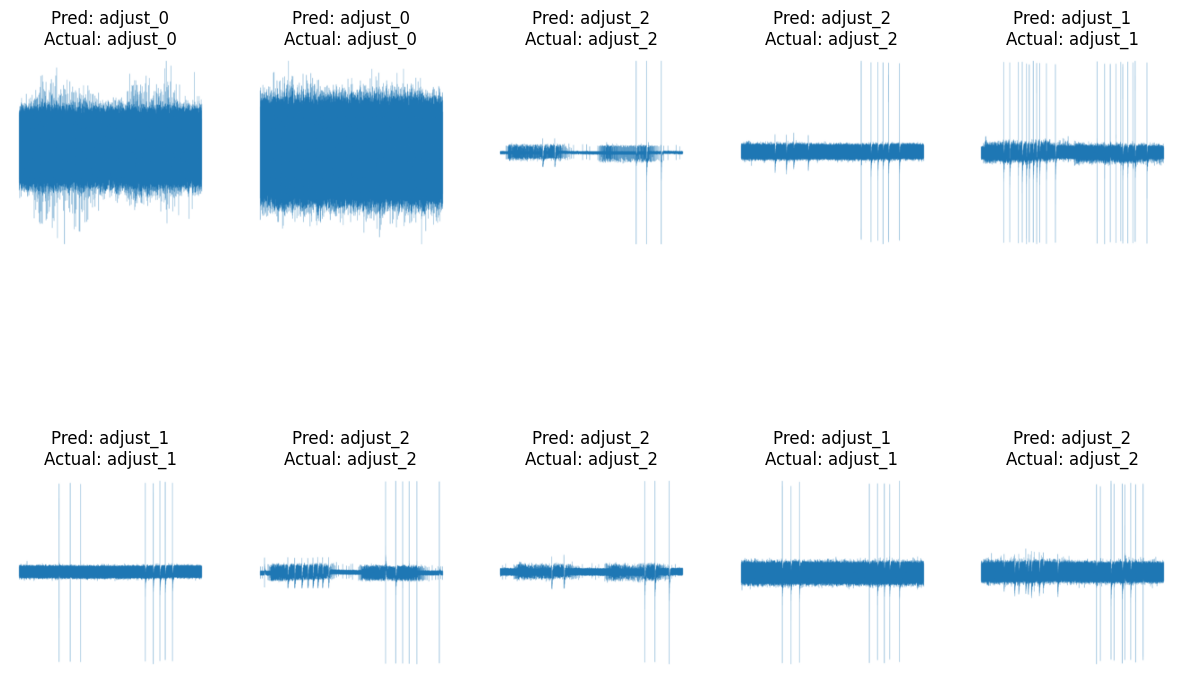

In [10]:
import matplotlib.pyplot as plt
import numpy as np
class_names = ['adjust_0', 'adjust_1', 'adjust_2', 'adjust_3']
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # 3 classes: 0, 1, 2, 3
model.load_state_dict(torch.load('/content/drive/MyDrive/VonResult/best_model_weights.pth'))
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()  # Set the model to evaluation mode
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    if title:
        ax.set_title(title)
    ax.axis('off')
    return ax

def display_predictions(model, data_loader, num_images=5):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//5, 5, images_so_far)
            ax.axis('off')
            imshow(inputs.cpu().data[j], ax=ax, title=f'Pred: {class_names[preds[j]]}\nActual: {class_names[labels[j]]}')
            if images_so_far == num_images:
                return

# Test with validation set
display_predictions(model, val_loader, num_images=10)


<ipython-input-11-23fb2b3ab580>:25: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  image = std * image + mean


Accuracy: 0.9688
Recall: 0.9688
F1 Score: 0.9668

Metrics Table:
     Metric     Score
0  Accuracy  0.968750
1    Recall  0.968750
2  F1 Score  0.966827


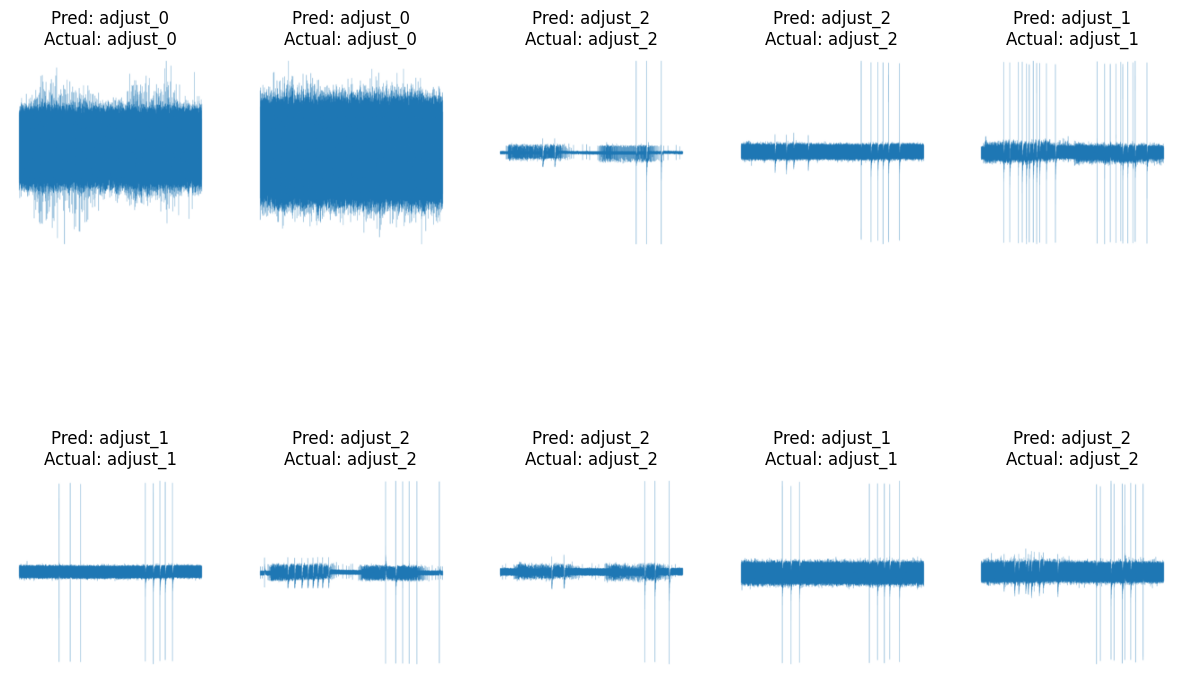

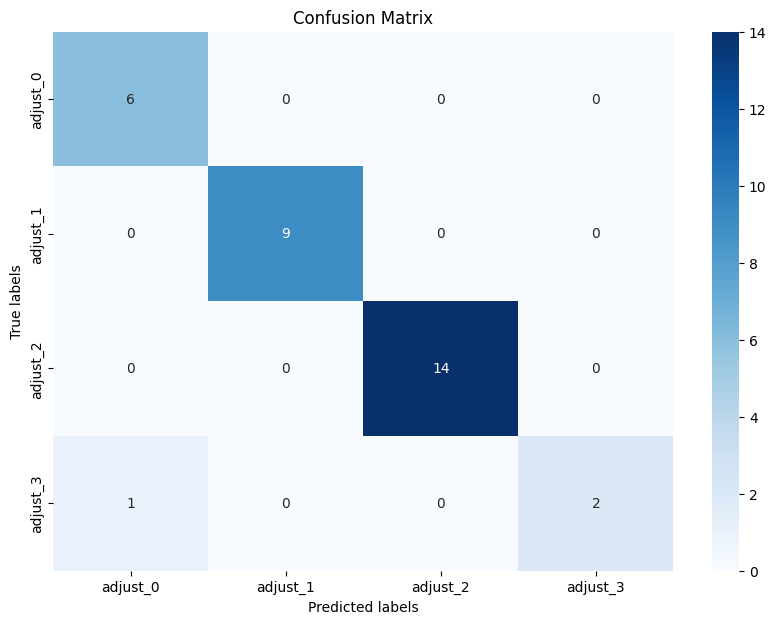

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import seaborn as sns
from torchvision import models
import pandas as pd

class_names = ['adjust_0', 'adjust_1', 'adjust_2', 'adjust_3']
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # 4 classes: 0, 1, 2, 3
model.load_state_dict(torch.load('/content/drive/MyDrive/VonResult/best_model_weights.pth'))
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()  # Set the model to evaluation mode

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    if title:
        ax.set_title(title)
    ax.axis('off')
    return ax

def display_predictions(model, data_loader, num_images_to_show=10, total_images=150):
    images_so_far = 0
    all_preds = []
    all_labels = []
    fig = plt.figure(figsize=(15, 10))

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Display only the first 'num_images_to_show' images
        if images_so_far < num_images_to_show:
            for j in range(inputs.size()[0]):
                if images_so_far >= num_images_to_show:
                    break
                images_so_far += 1
                ax = plt.subplot(num_images_to_show // 5, 5, images_so_far)
                ax.axis('off')
                imshow(inputs.cpu().data[j], ax=ax, title=f'Pred: {class_names[preds[j]]}\nActual: {class_names[labels[j]]}')

        if images_so_far >= num_images_to_show:
            break

    # Calculate metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    acc = accuracy_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    # Display metrics
    print(f'Accuracy: {acc:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Create a DataFrame for the metrics
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Recall', 'F1 Score'],
        'Score': [acc, rec, f1]
    })

    # Display the metrics table
    print("\nMetrics Table:")
    print(metrics_df)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Test with validation set, considering only a subset of images
display_predictions(model, val_loader, num_images_to_show=10, total_images=150)


In [17]:
##Test ảnh
from PIL import Image
import torch
import torchvision.transforms as transforms
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # 3 classes: 0, 1, 2, 3
model.load_state_dict(torch.load('/content/drive/MyDrive/VonResult/best_model_weights.pth'))
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()  # Set the model to evaluation mode



# Define the image transformations (same as during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the image
image_path = '/content/adjust_1_file10_chunk_0_noisy_filtered.png'  # Replace with your image path
image = Image.open(image_path).convert("RGB")

# Apply the transformations to the image
image = transform(image)
image = image.unsqueeze(0)  # Add a batch dimension (1, C, H, W)

# Move the image to the same device as the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
image = image.to(device)

# Make the prediction
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)

# Convert the predicted label to a class
class_labels = {0: 'adjust_0', 1: 'adjust_1', 2: 'adjust_2', 3: 'adjust_3'}
predicted_label = class_labels[predicted.item()]

print(f"The predicted class is: {predicted_label}")


The predicted class is: adjust_3
